In [14]:
#dataframe
import pandas as pd

#plots
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing

#model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#model assessment
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#tuning
from sklearn.model_selection import GridSearchCV

In [15]:
#Planning to use logistic regression, KNN, Random Forest


In [16]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head()

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8
3,0,1,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3
4,1,0,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18


<h3> Classes are inherently imbalanced

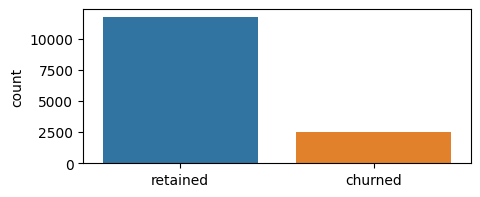

In [17]:
plt.figure(figsize = (5,2))
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [18]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [19]:
#The above cells show that the data is unbalanced. 
#Successful modelling may necessitate resampling to balance classes. 

<h3> Split data into testing and training datasets and standardiize

In [20]:
#Split data into testing and training datasets
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [32]:
#instantiate new model with C = .001
clf_lr = LogisticRegression( max_iter = 500, C = .001, random_state = 42)

<h2> Logistic Regression

In [33]:
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, max_iter=500, random_state=42)

In [34]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)
test_accuracy
#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)
train_accuracy
print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.8171328671328671
train accuracy: 0.8242853396275899


<h4> As expected, accuracies were slightly better using the new C values. Lets see the new confusion matrix

In [35]:
cm = confusion_matrix(y_test, y_predict, labels = clf_lr.classes_)
cm

array([[   2,  521],
       [   2, 2335]])

<h4> This shows significantly worse results. This model, while slightly improved in correctly predicting retention, correctly predicted only about half of the true churn, the target of this analysis. This is a good example of why we don't rely solely on accuracy for model testing.  

In [36]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     churned       0.50      0.00      0.01       523
    retained       0.82      1.00      0.90      2337

    accuracy                           0.82      2860
   macro avg       0.66      0.50      0.45      2860
weighted avg       0.76      0.82      0.74      2860



<h2> K Nearest Neighbors 

In [38]:
test_scores = []
train_scores = []

for i in range(1,10):

    clf_knn = KNeighborsClassifier(n_neighbors = i)
    clf_knn.fit(X_train_scaled,y_train)
    
    train_scores.append(clf_knn.score(X_train_scaled,y_train))
    test_scores.append(clf_knn.score(X_test_scaled,y_test))
print('train scores:', train_scores)
print('test scores:', test_scores)

train scores: [1.0, 0.8715796835387709, 0.8740274499519188, 0.8517352915464639, 0.8537459568144069, 0.8452661945974298, 0.8455284552845529, 0.8438674709327738, 0.8391467785645599]
test scores: [0.7534965034965035, 0.6748251748251748, 0.7965034965034965, 0.7688811188811189, 0.8041958041958042, 0.7835664335664335, 0.808041958041958, 0.7982517482517483, 0.8108391608391609]


<h2> Random Forest

In [27]:
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
model_res = clf_rf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest Accuracy = ', ac)
print('Random Forest f1-score =' , f1)

Random Forest Accuracy =  0.8132867132867133
Random Forest f1-score = 0.7674442686475628


In [28]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm

array([[  67,  456],
       [  78, 2259]])

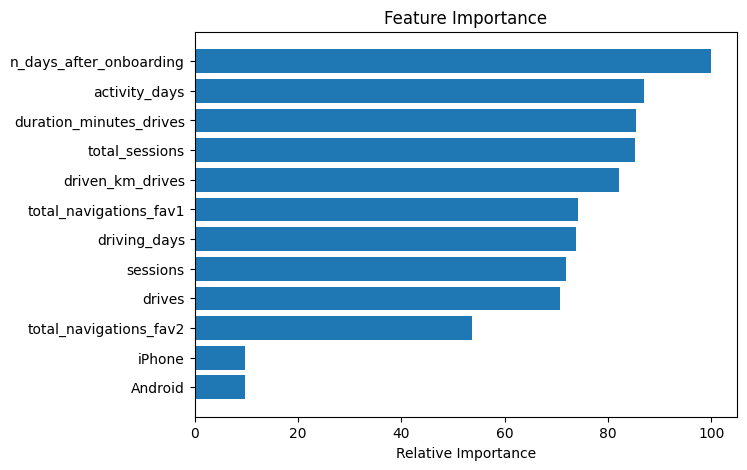

In [30]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show();